# Linear Models

*Summary: I decided to forego using a linear model in my final ensemble due to concerns about linear regression assumptions being violated.  In particular, residuals deviate slightly from the normal distribution and there are serious multi-collinearity concerns even with a regularized model.*

In [1]:
KAGGLE=False # set to True if using the Kaggle version of the dataset

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
#import sklearn.preprocessing

from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn import preprocessing
#from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold,KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso

from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [3]:
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 400)

The data has been pre-processed and stored to a dataframe

In [4]:
def load_data(tree=None):
    if KAGGLE:
        train = pd.read_csv('data/train.csv')
        test = pd.read_csv('data/test.csv')
        num_train=np.shape(train)[0]
        num_test=np.shape(test)[0]
        alldata=train.append(test, ignore_index=True)
    else:
        alldata=pd.read_csv('./data/Ames_HousePriceLocsDistNoDpl.csv')#, index_col=0) #already cleaned (see work in appendix files)

        #alldata=pd.read_csv('./data/Ames_HousePriceLocsDistNoDpl.csv')#, index_col=0) #already cleaned (see work in appendix files)
    return alldata

alldata=load_data()

- Choosing the best columns kept by lasso and RFs

In [7]:
nums = [col for col in alldata.columns if alldata.dtypes[col] != 'object']
cats = [col for col in alldata.columns if alldata.dtypes[col] == 'object']
alldata=pd.get_dummies(alldata).reset_index(drop=True)

In [8]:
#alldata['LogPrice']=np.log1p(alldata.SalePrice)
alldata['LogPrice']=np.log(alldata.SalePrice)

In [9]:
deps=list(set(alldata.columns)-set(['LogPrice','2ndFlrSF','SalePrice']))

In [10]:
def train_test_split_custom(data=alldata,y_var='SalePrice',cols=[]):
    y=data[y_var]
    X=data.drop([y_var],axis=1)
    X= X if not cols else X[cols]
    return train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split_custom(y_var='LogPrice', cols=deps)  

In [11]:
y=alldata['LogPrice'].values
X=alldata[deps].values
names = alldata[deps].columns

In [12]:
steps = [('scaling',StandardScaler()),
('lasso',Lasso(alpha=.01))]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split_custom(y_var='LogPrice', cols=deps)
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)


r2 score on train: 0.8967913557832541
r2 score on test: 0.9144110683556869


In [13]:
plt.rcParams["figure.figsize"] = (20, 10)
lasso_coef=pipeline['lasso'].coef_
names = X_train.columns
lasso_zips=zip(names,lasso_coef)
lasso_coef_clean = [tup for tup in lasso_zips if np.abs(tup[1])>.005]
names_clean = [tup[0] for tup in lasso_coef_clean]
coefs_clean = [tup[1] for tup in lasso_coef_clean]

In [14]:
lasso_coef_clean

[('GarageCond_Fa', -0.005781604522181727),
 ('Neighborhood_Crawfor', 0.01153405533420772),
 ('HeatingQC_Ex', 0.007692592859083174),
 ('Fireplaces', 0.01766366698137089),
 ('MSZoning_RM', -0.0224905285334538),
 ('KitchenQual_Ex', 0.0084604831214531),
 ('TotalBsmtSF', 0.03753685829371445),
 ('LotArea', 0.014187030758130366),
 ('Foundation_PConc', 0.011165555589382823),
 ('Condition1_Norm', 0.007334893919553833),
 ('OverallQual', 0.10351923285712065),
 ('YearBuilt', 0.044610392394328104),
 ('MSZoning_C (all)', -0.006111813807950725),
 ('SaleCondition_Abnorml', -0.00645064560628454),
 ('CentralAir_Y', 0.00797694999258864),
 ('Condition2_PosN', -0.008526846442367852),
 ('BsmtExposure_Gd', 0.006216803662263695),
 ('OverallCond', 0.03746557434173534),
 ('GarageArea', 0.01623566331243499),
 ('GarageCars', 0.018618907466918907),
 ('BsmtQual_Ex', 0.007630029158421298),
 ('BldgType_Twnhs', -0.005541579486971266),
 ('PavedDrive_N', -0.006170528981330109),
 ('BsmtFinSF1', 0.02936223829960516),
 ('G

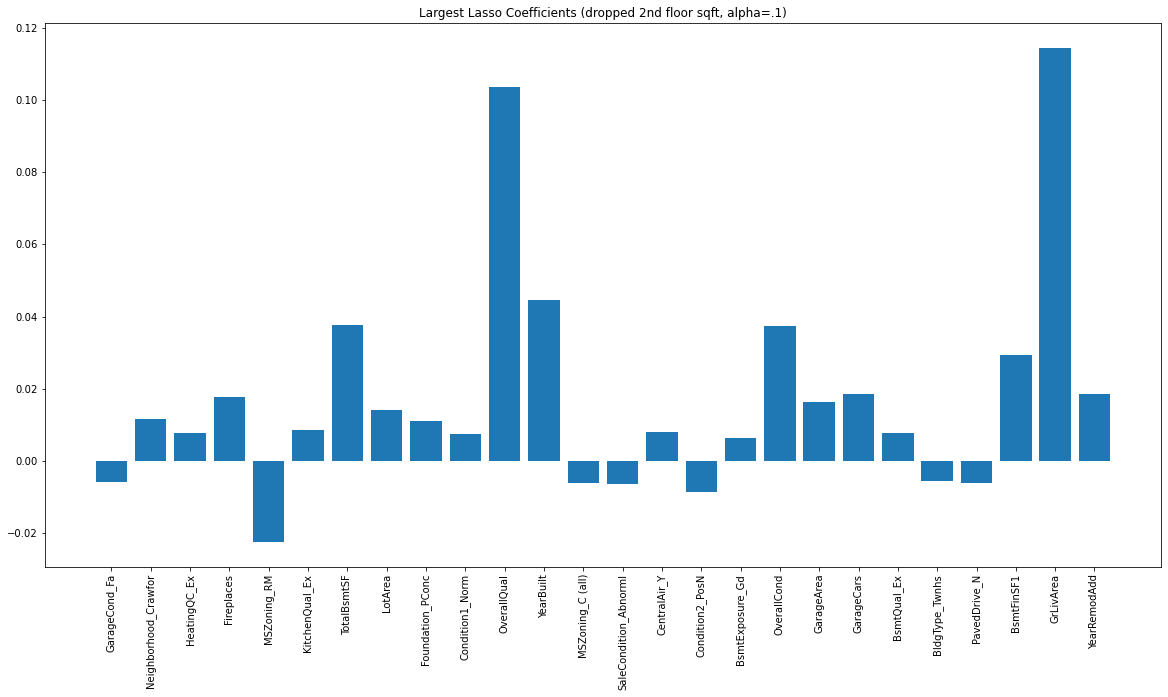

In [15]:
plt.bar(names_clean, coefs_clean)
plt.title('Largest Lasso Coefficients (dropped 2nd floor sqft, alpha=.1)')
plt.xticks(rotation=90)
plt.show()

In [16]:
from sklearn.linear_model import Lasso
from  sklearn.feature_selection import RFE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
rfe = RFE(estimator=Lasso(alpha=0.3,max_iter=10000), n_features_to_select=150,step=10,verbose=1)
rfe.fit(X_train,y_train)
cols_selected_lasso=list(alldata[deps].columns[rfe.support_])

Fitting estimator with 296 features.
Fitting estimator with 286 features.
Fitting estimator with 276 features.
Fitting estimator with 266 features.
Fitting estimator with 256 features.
Fitting estimator with 246 features.
Fitting estimator with 236 features.
Fitting estimator with 226 features.
Fitting estimator with 216 features.
Fitting estimator with 206 features.
Fitting estimator with 196 features.
Fitting estimator with 186 features.
Fitting estimator with 176 features.
Fitting estimator with 166 features.
Fitting estimator with 156 features.


In [17]:
cols_selected_lasso=list(X_train.columns[rfe.support_])

In [18]:
steps = [('scaling',StandardScaler()),
('linear',LinearRegression())]
pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split_custom(y_var='LogPrice', cols=names_clean)
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
#print(f'Lasso best params: {pipeline.best_params_}')


r2 score on train: 0.9108240645545975
r2 score on test: 0.9101318576525395


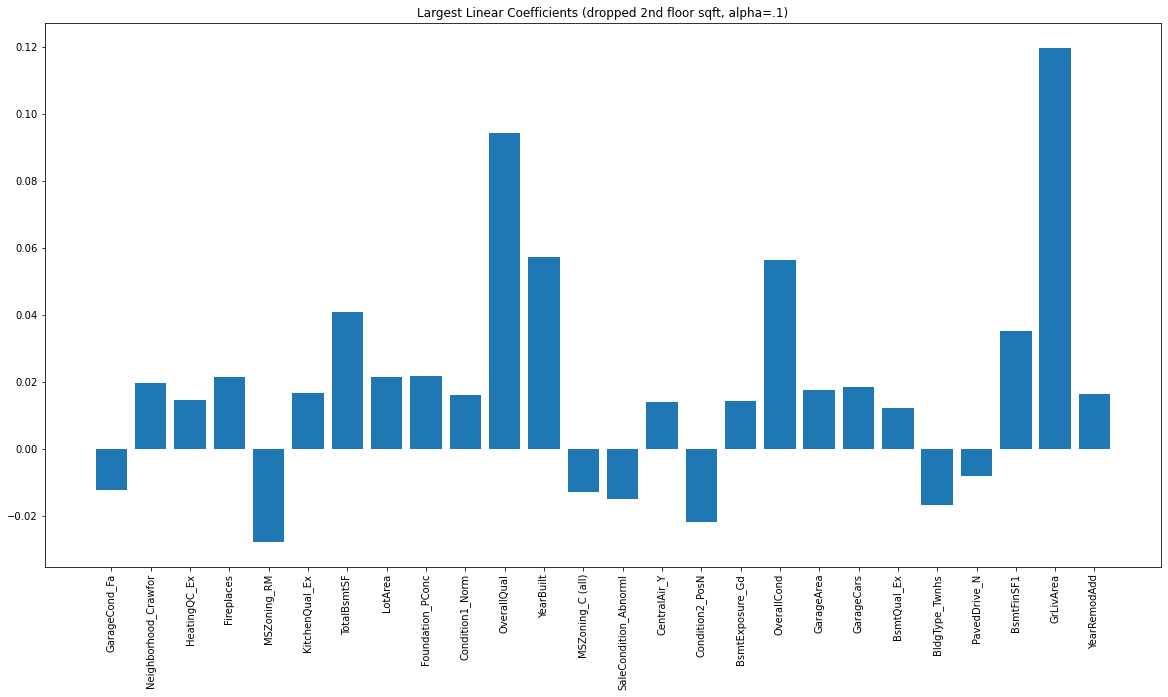

In [19]:
plt.rcParams["figure.figsize"] = (20, 10)
lin_coef=pipeline['linear'].coef_
names = X_train.columns
lin_zips=zip(names,lin_coef)
lin_coef_clean = [tup for tup in lin_zips if np.abs(tup[1])>.005]
names_clean_lin = [tup[0] for tup in lin_coef_clean]
coefs_clean_lin = [tup[1] for tup in lin_coef_clean]

plt.bar(names_clean_lin, coefs_clean_lin)
plt.title('Largest Linear Coefficients (dropped 2nd floor sqft, alpha=.1)')
plt.xticks(rotation=90)
plt.show()

In [20]:
pipeline['linear'].coef_

array([-0.01216276,  0.01957418,  0.01458694,  0.02154402, -0.02780353,
        0.01668885,  0.04074521,  0.0214734 ,  0.02185707,  0.0159822 ,
        0.09433916,  0.05709746, -0.01282419, -0.01499327,  0.0140958 ,
       -0.02178871,  0.01423816,  0.05648837,  0.01756977,  0.01844335,
        0.01225756, -0.01670534, -0.00809355,  0.03529937,  0.11961683,
        0.01632084])

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def print_vifs(data=alldata,coef_names=names_clean_lin):


    vif_data = pd.DataFrame()
    vif_data["feature"] = coef_names

    vif_data["VIF"] = [variance_inflation_factor(data[coef_names].values, i)
                              for i in range(len(data[coef_names].columns))]

    print(vif_data)

In [22]:
print_vifs()

                  feature           VIF
0           GarageCond_Fa      1.158803
1    Neighborhood_Crawfor      1.134378
2            HeatingQC_Ex      3.010343
3              Fireplaces      2.777683
4             MSZoning_RM      1.609773
5          KitchenQual_Ex      1.596113
6             TotalBsmtSF     14.283883
7                 LotArea      3.163930
8        Foundation_PConc      3.383015
9         Condition1_Norm      7.787694
10            OverallQual     59.426871
11              YearBuilt  13580.078080
12       MSZoning_C (all)      1.082794
13  SaleCondition_Abnorml      1.047192
14           CentralAir_Y     22.062463
15        Condition2_PosN      1.049728
16        BsmtExposure_Gd      1.398580
17            OverallCond     44.727832
18             GarageArea     31.876430
19             GarageCars     36.852685
20            BsmtQual_Ex      1.798217
21         BldgType_Twnhs      1.180335
22           PavedDrive_N      1.558520
23             BsmtFinSF1      3.266594


In [23]:
steps = [('scaling',StandardScaler()),
('linear',LinearRegression())]
pipeline = Pipeline(steps)
names_clean_no_remod = list(set(names_clean) - set(['YearRemodAdd']))
X_train, X_test, y_train, y_test = train_test_split_custom(y_var='LogPrice', cols=names_clean_no_remod)
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
#print(f'Lasso best params: {pipeline.best_params_}')


r2 score on train: 0.9098396380823348
r2 score on test: 0.9102371501945037


In [24]:
print_vifs(data=alldata,coef_names=names_clean_no_remod)

                  feature        VIF
0   SaleCondition_Abnorml   1.047161
1             MSZoning_RM   1.512265
2             BsmtQual_Ex   1.798184
3             OverallQual  59.298372
4         BsmtExposure_Gd   1.398486
5            CentralAir_Y  21.725221
6              GarageCars  36.672533
7              BsmtFinSF1   3.238927
8          BldgType_Twnhs   1.166480
9            PavedDrive_N   1.451583
10              YearBuilt  81.940077
11       MSZoning_C (all)   1.078776
12                LotArea   3.159717
13          GarageCond_Fa   1.152551
14            TotalBsmtSF  14.281894
15   Neighborhood_Crawfor   1.123014
16       Foundation_PConc   3.368982
17            OverallCond  31.843714
18             Fireplaces   2.776979
19        Condition1_Norm   7.787594
20        Condition2_PosN   1.049658
21         KitchenQual_Ex   1.594632
22           HeatingQC_Ex   2.995787
23              GrLivArea  19.222651
24             GarageArea  31.867112


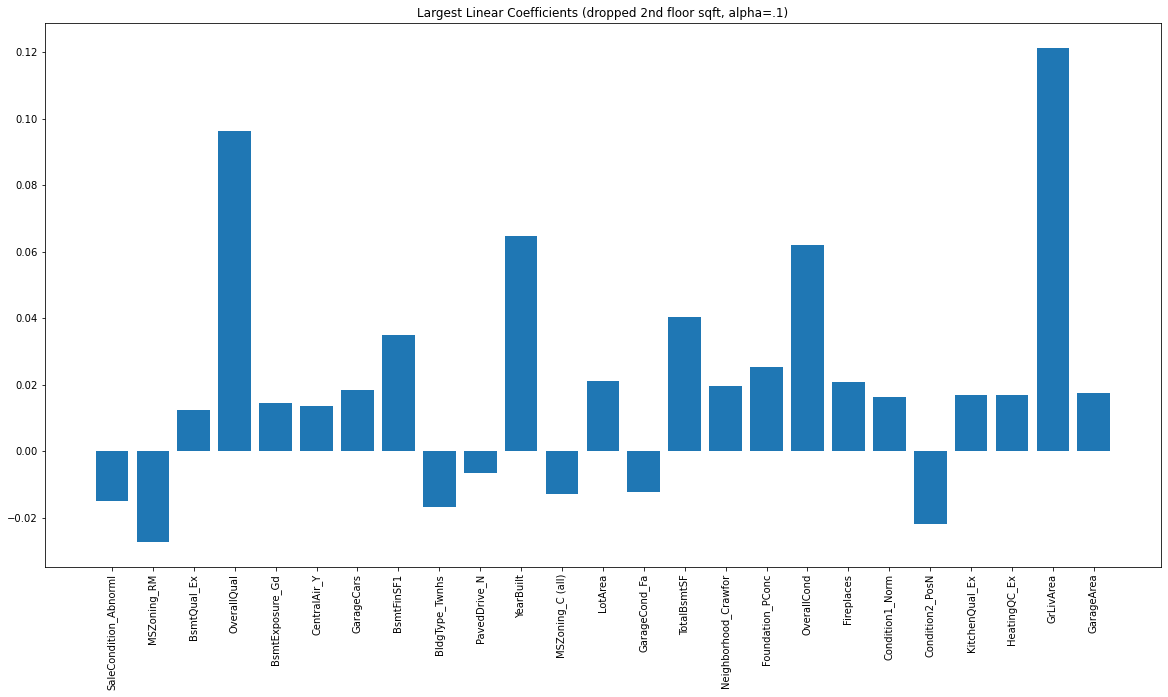

In [25]:
plt.rcParams["figure.figsize"] = (20, 10)
lin_coef=pipeline['linear'].coef_
names = X_train.columns
lin_zips=zip(names,lin_coef)
lin_coef_clean = [tup for tup in lin_zips if np.abs(tup[1])>.005]
names_clean_lin = [tup[0] for tup in lin_coef_clean]
coefs_clean_lin = [tup[1] for tup in lin_coef_clean]

plt.bar(names_clean_lin, coefs_clean_lin)
plt.title('Largest Linear Coefficients (dropped 2nd floor sqft, alpha=.1)')
plt.xticks(rotation=90)
plt.show()

In [26]:
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train,X_train)
results = model.fit()
print(results.summary()) # How to print out the summary report

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     896.2
Date:                Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:35:56   Log-Likelihood:                 1618.0
No. Observations:                2046   AIC:                            -3184.
Df Residuals:                    2020   BIC:                            -3038.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.16

In [27]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)
# Notice that the dependent variable (y) comes before the independent variables (x)
# Use df.columns.values to get all the column names
model = sm.OLS(y_train,X_train)
results = model.fit(cov_type="hc0")
print(results.summary()) # How to print out the summary report

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     933.0
Date:                Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:35:57   Log-Likelihood:                 1618.0
No. Observations:                2046   AIC:                            -3184.
Df Residuals:                    2020   BIC:                            -3038.
Df Model:                          25                                         
Covariance Type:                  hc0                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.16

In [28]:
steps = [('scaling',StandardScaler()),
('linear',LinearRegression())]
pipeline = Pipeline(steps)
names_clean_no_remod = list(set(names_clean) - set(['YearRemodAdd','Condition2_PosN','GarageCond_Fa','TotalBsmtSF','LotArea','Condition1_Norm']))
X_train, X_test, y_train, y_test = train_test_split_custom(y_var='LogPrice', cols=names_clean_no_remod)
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
#print(f'Lasso best params: {pipeline.best_params_}')

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train,X_train)
results = model.fit(cov_type="hc0")
print(results.summary()) # How to print out the summary report

r2 score on train: 0.8930118826217536
r2 score on test: 0.902139546320394
                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     759.1
Date:                Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:35:58   Log-Likelihood:                 1458.6
No. Observations:                2046   AIC:                            -2875.
Df Residuals:                    2025   BIC:                            -2757.
Df Model:                          20                                         
Covariance Type:                  hc0                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

In [29]:
steps = [('scaling',StandardScaler()),
('linear',LinearRegression())]
pipeline = Pipeline(steps)
names_clean_no_remod = list(set(names_clean) - set(['YearRemodAdd','Condition2_PosN','GarageCond_Fa','TotalBsmtSF','LotArea','Condition1_Norm']))
X_train, X_test, y_train, y_test = train_test_split_custom(y_var='LogPrice', cols=names_clean_no_remod)
pipeline.fit(X_train,y_train)
preds = pipeline.predict(X_test)
print(f'r2 score on train: {r2_score(pipeline.predict(X_train), y_train)}\nr2 score on test: {r2_score(y_test, preds)}')# plt.bar(names, lasso_coef)
#print(f'Lasso best params: {pipeline.best_params_}')

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train,X_train)
results = model.fit(cov_type="hc0")
print(results.summary()) # How to print out the summary report

r2 score on train: 0.8930118826217536
r2 score on test: 0.902139546320394
                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     759.1
Date:                Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:35:58   Log-Likelihood:                 1458.6
No. Observations:                2046   AIC:                            -2875.
Df Residuals:                    2025   BIC:                            -2757.
Df Model:                          20                                         
Covariance Type:                  hc0                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

In [30]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               LogPrice   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     759.1
Date:                Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:36:00   Log-Likelihood:                 1458.6
No. Observations:                2046   AIC:                            -2875.
Df Residuals:                    2025   BIC:                            -2757.
Df Model:                          20                                         
Covariance Type:                  hc0                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.1753      0.372     16.589      0.000       5.446       6.905
SaleCondition_Abnorml    -0.0870      0.039     -2.250      0.024      -0.163      -0.011
MSZoning_RM              -0.0954      0.010     -9.920      0.000      -0.114      -0.077
BsmtQual_Ex               0.0516      0.012      4.236      0.000       0.028       0.076
BsmtExposure_Gd           0.0614      0.010      6.146      0.000       0.042       0.081
CentralAir_Y              0.0710      0.017      4.104      0.000       0.037       0.105
BldgType_Twnhs           -0.1216      0.012    -10.139      0.000      -0.145      -0.098
PavedDrive_N             -0.0334      0.016     -2.101      0.036      -0.065      -0.002
Neighborhood_Crawfor      0.1085      0.016      6.880      0.000       0.078       0.139
OverallCond               0.0525      0.004     14.930      0.000       0.046       0.059
HeatingQC_Ex              0.0335      0.006      5.602      0.000       0.022       0.045
GarageArea                0.0001    3.8e-05      3.700      0.000    6.61e-05       0.000
OverallQual               0.0771      0.004     18.333      0.000       0.069       0.085
GarageCars                0.0185      0.009      2.144      0.032       0.002       0.035
BsmtFinSF1                0.0001   9.69e-06     11.426      0.000    9.18e-05       0.000
YearBuilt                 0.0022      0.000     11.761      0.000       0.002       0.003
MSZoning_C (all)         -0.1840      0.069     -2.679      0.007      -0.319      -0.049
Foundation_PConc          0.0470      0.008      5.603      0.000       0.031       0.063
Fireplaces                0.0354      0.008      4.705      0.000       0.021       0.050
KitchenQual_Ex            0.0740      0.014      5.338      0.000       0.047       0.101
GrLivArea                 0.0003   1.67e-05     15.796      0.000       0.000       0.000
==============================================================================
Omnibus:                     1346.546   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78819.332
Skew:                          -2.406   Prob(JB):                         0.00
Kurtosis:                      33.024   Cond. No.                     3.36e+05
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 3.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
df = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0]

In [32]:
df.head()

,coef,std err,z,P>|z|,[0.025,0.975]
const,6.1753,0.372,16.589,0.000,5.446,6.905
SaleCondition_Abnorml,-0.0870,0.039,-2.250,0.024,-0.163,-0.011
MSZoning_RM,-0.0954,0.010,-9.920,0.000,-0.114,-0.077
BsmtQual_Ex,0.0516,0.012,4.236,0.000,0.028,0.076
BsmtExposure_Gd,0.0614,0.010,6.146,0.000,0.042,0.081


In [34]:
df['coef_exp']=np.exp(df['coef'])

In [35]:
df

,coef,std err,z,P>|z|,[0.025,0.975],coef_exp
const,6.1753,0.372000,16.589,0.000,5.446000,6.905,480.727220
SaleCondition_Abnorml,-0.0870,0.039000,-2.250,0.024,-0.163000,-0.011,0.916677
MSZoning_RM,-0.0954,0.010000,-9.920,0.000,-0.114000,-0.077,0.909009
BsmtQual_Ex,0.0516,0.012000,4.236,0.000,0.028000,0.076,1.052954
BsmtExposure_Gd,0.0614,0.010000,6.146,0.000,0.042000,0.081,1.063324
CentralAir_Y,0.0710,0.017000,4.104,0.000,0.037000,0.105,1.073581
BldgType_Twnhs,-0.1216,0.012000,-10.139,0.000,-0.145000,-0.098,0.885502
PavedDrive_N,-0.0334,0.016000,-2.101,0.036,-0.065000,-0.002,0.967152
Neighborhood_Crawfor,0.1085,0.016000,6.880,0.000,0.078000,0.139,1.114605
OverallCond,0.0525,0.004000,14.930,0.000,0.046000,0.059,1.053903


- Multiply the coefficients of the linear regression by the average house price to interpret the effect of unit change on average price

In [36]:
df['efct_on_avg_price']=178059.62325581396*df['coef']

In [37]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [38]:
df

,coef,std err,z,P>|z|,[0.025,0.975],coef_exp,efct_on_avg_price
const,6.17530,0.37200,16.58900,0.00000,5.44600,6.90500,480.72722,1099571.59149
SaleCondition_Abnorml,-0.08700,0.03900,-2.25000,0.02400,-0.16300,-0.01100,0.91668,-15491.18722
MSZoning_RM,-0.09540,0.01000,-9.92000,0.00000,-0.11400,-0.07700,0.90901,-16986.88806
BsmtQual_Ex,0.05160,0.01200,4.23600,0.00000,0.02800,0.07600,1.05295,9187.87656
BsmtExposure_Gd,0.06140,0.01000,6.14600,0.00000,0.04200,0.08100,1.06332,10932.86087
CentralAir_Y,0.07100,0.01700,4.10400,0.00000,0.03700,0.10500,1.07358,12642.23325
BldgType_Twnhs,-0.12160,0.01200,-10.13900,0.00000,-0.14500,-0.09800,0.88550,-21652.05019
PavedDrive_N,-0.03340,0.01600,-2.10100,0.03600,-0.06500,-0.00200,0.96715,-5947.19142
Neighborhood_Crawfor,0.10850,0.01600,6.88000,0.00000,0.07800,0.13900,1.11460,19319.46912
OverallCond,0.05250,0.00400,14.93000,0.00000,0.04600,0.05900,1.05390,9348.13022


In [39]:
df_export = df[['coef','efct_on_avg_price']]

In [40]:
df_export[['efct_on_avg_price']].iloc[1:,:]

,efct_on_avg_price
SaleCondition_Abnorml,-15491.18722
MSZoning_RM,-16986.88806
BsmtQual_Ex,9187.87656
BsmtExposure_Gd,10932.86087
CentralAir_Y,12642.23325
BldgType_Twnhs,-21652.05019
PavedDrive_N,-5947.19142
Neighborhood_Crawfor,19319.46912
OverallCond,9348.13022
HeatingQC_Ex,5964.99738
